# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2022**

**Мягкий дедлайн: 03.06.2022 23:59 MSK**

**Жёсткий дедлайн: 08.06.2022 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [4]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [5]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [6]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [7]:
def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    preds = np.array(predicted)
    preds = preds[:,:k]
    mask = np.array([[x in relevant[i] for x in preds[i]] for i in range(len(preds))])
    p = np.cumsum(mask.astype(int), axis=1) / np.arange(1, k + 1)
    coef = np.clip(np.array([len(rel) for rel in relevant]), -1, k)
    return np.mean(np.sum((p * mask), axis=1) / coef)

In [8]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [9]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [10]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [11]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [12]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [13]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [14]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [15]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [16]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [17]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            if user_id >= len(preds):
                break
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = []
        for user_id in range(self.n_users):
            test_preds.append(self.recommend(user_id))
        test_preds = self.remove_train_items(test_preds, k)
        
        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [18]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    num = ratings @ user_vector
    denum = np.sqrt(np.sum(ratings, axis=1))

    return num / denum / np.sqrt(np.sum(user_vector))
    


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    num = ratings @ user_vector
    denum = ratings @ np.ones(len(user_vector)) + np.sum(user_vector) - num
    
    return num / denum

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [19]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        """
        distances = np.asarray(self.similarity_func(self.R, user_vector)).reshape(-1)
        sorted_args = np.argsort(-distances)
        tmp = distances[sorted_args]
        mask = (tmp >= self.alpha)
        if not mask[1]:      
            mask[1] = True
        sorted_args = sorted_args[mask]
        return sorted_args[1:], distances[sorted_args][1:]

    def recommend(self, uid: int):
        closest_users, dist = self.similarity(self.R[uid])
        neigh_raitings = self.R[closest_users, :]
        predicts = dist.T @ neigh_raitings / np.sum(np.abs(dist))
        
        return np.argsort(-predicts)

In [20]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    num = ratings @ user_vector.reshape(-1, 1)
    denum = np.sqrt(np.sum(ratings, axis=1)).reshape(-1, 1) 

    return num / denum / np.sqrt(np.sum(user_vector))
    


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    num = ratings @ user_vector.reshape(-1, 1)
    denum = ratings.sum(axis=1).reshape(-1, 1) + np.sum(user_vector) - num
    return num / denum

In [21]:
model = User2User(train_ratings, pearson)
preds = []
for user in tqdm(test_users):
    preds.append(model.recommend(user))
preds = model.remove_train_items(preds, 10)
mapk(test_relevant, preds, k=10)

  0%|          | 0/235 [00:00<?, ?it/s]

0.0006997635933806147

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [105]:
pearson_scores = []
jaccard_scoreds = []
random_scores = []
ks = np.arange(1, 51, 5)

for k in tqdm(ks):
    model = User2User(train_ratings, pearson)
    preds = model.get_test_recommendations(k)
    pearson_scores.append(mapk(test_relevant, preds, k=k))
    
    model = User2User(train_ratings, jaccard)
    preds = model.get_test_recommendations(k)
    jaccard_scoreds.append(mapk(test_relevant, preds, k=k))
    
    preds = []
    for user in test_users:
        random_args = np.arange(model.n_items)
        np.random.shuffle(random_args)
        preds.append(random_args)
    preds = model.remove_train_items(preds, k)
    random_scores.append(mapk(test_relevant, preds, k=k))
    
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

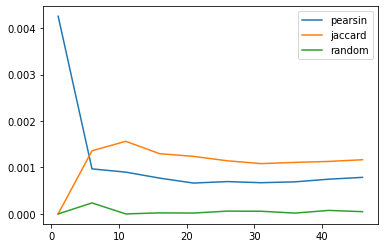

In [106]:
plt.plot(ks, pearson_scores, label='pearsin')
plt.plot(ks, jaccard_scoreds, label='jaccard')
plt.plot(ks, random_scores, label='random')
plt.legend()
plt.show()

**Бонус (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [22]:
from scipy.sparse import csr_matrix

class User2UserSparse(User2User):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings, similarity_func)
        self.R = csr_matrix(self.R)

In [24]:
model = User2UserSparse(train_ratings, pearson)
preds = []
for user in tqdm(test_users):
    preds.append(model.recommend(user))
preds = model.remove_train_items(preds, 10)
mapk(test_relevant, preds, k=10)

  0%|          | 0/235 [00:00<?, ?it/s]

0.0006997635933806147

Скорость работы, как и ожидалось, на порядки выше

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [25]:
user_id = np.random.randint(0, model.n_users)

In [26]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
215,Lick It Up,['Kiss']
220,I Was Made For Lovin' You,['Kiss']
222,I Go To Sleep,['Sia']
379,Sway,['The Pussycat Dolls']
391,Autumn Serenade,"['John Coltrane', 'Johnny Hartman']"
518,Desafinado,"['Stan Getz', 'Charlie Byrd']"
541,Moonlight And Vodka,['Chris De Burgh']
898,Desnúdate Mujer,['David Bisbal']
1316,Tears In Heaven,['Eric Clapton']
1865,та4то,['Бумбокс']


In [27]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
31358,Rockabye,"['Clean Bandit', 'Sean Paul', 'Anne-Marie']"
24500,Way Down We Go,['KALEO']
19452,Prayer in C,"['Robin Schulz', 'Lilly Wood & The Prick']"
18459,Take Me To Church,['Hozier']
805,Zombie,['The Cranberries']
24995,Runnin' (Lose It All),"['Naughty Boy', 'Beyoncé', 'Arrow Benjamin']"
20218,I'm Not The Only One,['Sam Smith']
22325,Dancin,"['Aaron Smith', 'Krono', 'Luvli']"
12253,Friends,"['Aura Dione', 'Rock Mafia']"
15877,Get Lucky,"['Daft Punk', 'Pharrell Williams', 'Nile Rodge..."


In [28]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
19178,До рассвета,"['Arsenium', 'Сати Казанова']"
19379,Улыбайся,['IOWA']
19725,Time in a Bottle,['Jim Croce']
19820,Time In A Bottle,['Jim Croce']
20448,Je T'aime,['Lara Fabian']
20827,Ooh Ahh (My Life Be Like),"['Grits', 'TobyMac']"
20979,Маршрутка,['IOWA']
21081,Лифт,['PIZZA']
21628,Одно и то же,['IOWA']
22068,Лишь небо знает,['Доминик Джокер']


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 6 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Посчитаем производную по $p_k:$

$\frac{\partial}{\partial p_k} = \sum_{(u, i)} [u=k] 2(<p_u, q_i> - r_{ui})q_i + 2\lambda p_k$

В матричном виде: $\frac{\partial}{\partial P} = 2(PQ^TQ - RQ + \lambda P)$, где $Q \in \mathbb{R}^{(m, d)}, P \in \mathbb{R}^{(n, d)}$

Посчитаем производную по $q_k:$

$\frac{\partial}{\partial q_k} = \sum_{(u, i)} [i=k] 2(<p_u, q_i> - r_{ui})r_u + 2\lambda q_k$

В матричном виде: $\frac{\partial}{\partial Q} = 2(QP^TP - R^TP + \lambda Q)$

Итого:

$P_{n+1} = P_n - \eta \frac{\partial}{\partial P}(P_n, Q_n)\\
Q_{n+1} = Q_n - \eta \frac{\partial}{\partial Q}(P_n, Q_n)$

\\
**ALS:**

Приравняем производные к нулю.

$2(PQ^TQ - RQ + \lambda P) = 0 \Rightarrow P(Q^TQ + \lambda I) = RQ \Rightarrow P_{n + 1} = RQ_n(Q_n^TQ_n + \lambda I)^{-1}$

$2(QP^TP - R^TP + \lambda Q) = 0 \Rightarrow Q(P^TP + \lambda I) = R^TP \Rightarrow Q_{n+1} = R^TP_{n+1}(P_{n+1}^TP_{n+1} + \lambda I)^{-1}$ 
 



**Задание 7 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [139]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', lamb=0.01, lr=3e-4):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.n_users, dim))
        self.Q = np.random.normal(size=(self.n_items, dim))
        self.P = self.P / np.linalg.norm(self.P) # если не нормировать ининциализацию, то норма улетает в помойку (в sgd так точно)
        self.Q = self.Q / np.linalg.norm(self.Q) 

        self.lr = lr
        self.lamb = lamb

    def fit(self, num_iters=5):
        for epoch in range(num_iters):

            if self.mode == 'sgd':
                delta_p = 2 * (self.P @ (self.Q.T @ self.Q) - self.R @ self.Q + self.lamb * self.P)
                delta_q = 2 * (self.Q @ (self.P.T @ self.P) - self.R.T @ self.P + self.lamb * self.Q)
                self.P -= self.lr * delta_p
                self.Q -= self.lr * delta_q

            elif self.mode == 'als':
                self.P = self.R @ self.Q @ np.linalg.inv(self.Q.T @ self.Q + self.lamb * np.eye(self.Q.shape[1]))
                self.Q = self.R.T @ self.P @ np.linalg.inv(self.P.T @ self.P + self.lamb * np.eye(self.P.shape[1]))

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T

        return np.argsort(pred_rating)[::-1]

In [140]:
model = HiddenVars(train_ratings, mode='sgd')
model.fit()
preds = model.get_test_recommendations(k)
score = mapk(test_relevant, preds, k=k)

In [141]:
score

0.00016757152012667547

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [45]:
import optuna

optuna.logging.set_verbosity(optuna.logging.INFO)

In [142]:
def objective_sgd(trial):
    d = trial.suggest_int('d', 32, 512, log=False)
    k = trial.suggest_int('k', 1, 30, log=False)
    num_iters = trial.suggest_int('num_iters', 1, 30, log=False)
    lambd = trial.suggest_float('lambd', 1e-3, 100, log=True)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    model = HiddenVars(train_ratings, dim=d, mode='sgd', lamb=lambd, lr=lr)
    model.fit(num_iters=num_iters)
    preds = model.get_test_recommendations(k)
    score = mapk(test_relevant, preds, k=k)

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective_sgd, n_trials=100, n_jobs=-1)
best_trial = study.best_trial
study.best_value

[I 2022-06-06 23:30:08,458] A new study created in memory with name: no-name-85b325cf-28df-4da5-98af-438a6d265ac0
C:\Users\Denis\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-06-06 23:30:20,869] Trial 2 finished with value: 0.0 and parameters: {'d': 40, 'k': 2, 'num_iters': 19, 'lambd': 0.6691819525709201, 'lr': 0.001147507376280707}. Best is trial 2 with value: 0.0.
[I 2022-06-06 23:30:23,405] Trial 1 finished with value: 0.0015436917298619424 and parameters: {'d': 49, 'k': 12, 'num_iters': 28, 'lambd': 13.568094065988829, 'lr': 0.000870060885136589}. Best is trial 1 with value: 0.0015436917298619424.
[I 2022-06-06 23:30:25,337] Trial 0 finished with value: 0.0 and parameters: {'d': 78, 'k': 2, 'num_iters': 27, 'lambd': 1.7288541140658586, 'lr': 0.00013522986198111282}. Best is trial 1 with v

[I 2022-06-06 23:36:49,533] Trial 34 finished with value: 7.354872603099554e-05 and parameters: {'d': 321, 'k': 18, 'num_iters': 8, 'lambd': 0.2010744548391399, 'lr': 0.00017060961137137497}. Best is trial 1 with value: 0.0015436917298619424.
[I 2022-06-06 23:37:21,212] Trial 32 finished with value: 0.0006737588652482269 and parameters: {'d': 391, 'k': 6, 'num_iters': 27, 'lambd': 1.33148382890885, 'lr': 0.0006808966521990821}. Best is trial 1 with value: 0.0015436917298619424.
[I 2022-06-06 23:37:25,653] Trial 33 finished with value: 0.00017520668093499517 and parameters: {'d': 387, 'k': 13, 'num_iters': 27, 'lambd': 1.2743203196150925, 'lr': 0.00012281379648537192}. Best is trial 1 with value: 0.0015436917298619424.
[I 2022-06-06 23:37:27,247] Trial 35 finished with value: 0.0006063676276442234 and parameters: {'d': 307, 'k': 12, 'num_iters': 28, 'lambd': 0.18296756309034992, 'lr': 0.000980590483592407}. Best is trial 1 with value: 0.0015436917298619424.
[I 2022-06-06 23:37:42,935] T

[I 2022-06-06 23:39:27,929] Trial 63 finished with value: 0.0 and parameters: {'d': 178, 'k': 5, 'num_iters': 16, 'lambd': 55.430501710540796, 'lr': 0.00035210781112935704}. Best is trial 40 with value: 0.00851063829787234.
[I 2022-06-06 23:39:38,869] Trial 66 finished with value: 0.0024113475177304964 and parameters: {'d': 32, 'k': 5, 'num_iters': 18, 'lambd': 3.888042562356483, 'lr': 0.0013545186021774608}. Best is trial 40 with value: 0.00851063829787234.
[I 2022-06-06 23:39:42,417] Trial 68 finished with value: 0.002127659574468085 and parameters: {'d': 85, 'k': 3, 'num_iters': 18, 'lambd': 3.9397083166433227, 'lr': 0.0007527271570081514}. Best is trial 40 with value: 0.00851063829787234.
[I 2022-06-06 23:39:42,588] Trial 69 finished with value: 0.009456264775413711 and parameters: {'d': 85, 'k': 3, 'num_iters': 18, 'lambd': 3.7501331528715, 'lr': 0.0008570695892425918}. Best is trial 69 with value: 0.009456264775413711.
[I 2022-06-06 23:39:48,383] Trial 67 finished with value: 0.0

[I 2022-06-06 23:41:27,895] Trial 98 finished with value: 0.0 and parameters: {'d': 130, 'k': 2, 'num_iters': 19, 'lambd': 0.5677221521337793, 'lr': 0.0002903194875355859}. Best is trial 69 with value: 0.009456264775413711.
[I 2022-06-06 23:41:33,920] Trial 99 finished with value: 0.0 and parameters: {'d': 196, 'k': 2, 'num_iters': 19, 'lambd': 1.5260563140468097, 'lr': 0.00032474651261990204}. Best is trial 69 with value: 0.009456264775413711.


0.009456264775413711

In [143]:
study.best_params

{'d': 85,
 'k': 3,
 'num_iters': 18,
 'lambd': 3.7501331528715,
 'lr': 0.0008570695892425918}

In [144]:
%%time
def objective_als(trial):
    d = trial.suggest_int('d', 32, 512, log=False)
    k = trial.suggest_int('k', 1, 30, log=False)
    num_iters = trial.suggest_int('num_iters', 1, 30, log=False)
    lambd = trial.suggest_float('lambd', 1e-3, 100, log=True)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    model = HiddenVars(train_ratings, dim=d, mode='als', lamb=lambd, lr=lr)
    model.fit(num_iters=num_iters)
    preds = model.get_test_recommendations(k)
    score = mapk(test_relevant, preds, k=k)

    return score


study = optuna.create_study(direction='maximize')
study.optimize(objective_als, n_trials=100, n_jobs=-1)
best_trial = study.best_trial
study.best_value

[I 2022-06-06 23:43:26,655] A new study created in memory with name: no-name-eaf215f7-0634-4188-8496-79722a2bbb9e
C:\Users\Denis\anaconda3\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2022-06-06 23:43:53,946] Trial 2 finished with value: 0.0016769860032271378 and parameters: {'d': 436, 'k': 9, 'num_iters': 10, 'lambd': 0.0014603470405238862, 'lr': 0.001900858573196799}. Best is trial 2 with value: 0.0016769860032271378.
[I 2022-06-06 23:43:55,090] Trial 3 finished with value: 0.0004913267058657129 and parameters: {'d': 207, 'k': 18, 'num_iters': 15, 'lambd': 0.009066866207326146, 'lr': 0.0017189458041118148}. Best is trial 2 with value: 0.0016769860032271378.
[I 2022-06-06 23:43:56,471] Trial 0 finished with value: 0.0014337108608794371 and parameters: {'d': 381, 'k': 13, 'num_iters': 14, 'lambd': 16.215393

[I 2022-06-06 23:47:13,741] Trial 32 finished with value: 0.0012776842757500398 and parameters: {'d': 400, 'k': 11, 'num_iters': 17, 'lambd': 0.05936835382878526, 'lr': 0.0025527219655236424}. Best is trial 16 with value: 0.00425531914893617.
[I 2022-06-06 23:47:21,910] Trial 33 finished with value: 0.0019745209300335025 and parameters: {'d': 415, 'k': 11, 'num_iters': 17, 'lambd': 0.07756593185826516, 'lr': 0.00017054622227594292}. Best is trial 16 with value: 0.00425531914893617.
[I 2022-06-06 23:47:24,622] Trial 35 finished with value: 0.0018912529550827422 and parameters: {'d': 195, 'k': 3, 'num_iters': 13, 'lambd': 0.10686076301541039, 'lr': 0.00019444715179003588}. Best is trial 16 with value: 0.00425531914893617.
[I 2022-06-06 23:47:27,489] Trial 34 finished with value: 0.0011911181446964815 and parameters: {'d': 429, 'k': 11, 'num_iters': 17, 'lambd': 0.08512627903280456, 'lr': 0.0009475823047374143}. Best is trial 16 with value: 0.00425531914893617.
[I 2022-06-06 23:47:30,222]

[I 2022-06-06 23:51:23,669] Trial 65 finished with value: 0.0 and parameters: {'d': 249, 'k': 1, 'num_iters': 24, 'lambd': 0.010613742441477355, 'lr': 0.005361538154114762}. Best is trial 58 with value: 0.009574468085106383.
[I 2022-06-06 23:51:28,006] Trial 66 finished with value: 0.0033687943262411344 and parameters: {'d': 245, 'k': 4, 'num_iters': 24, 'lambd': 0.016217067251011425, 'lr': 0.005614570175183053}. Best is trial 58 with value: 0.009574468085106383.
[I 2022-06-06 23:51:45,996] Trial 67 finished with value: 0.0013297872340425532 and parameters: {'d': 248, 'k': 4, 'num_iters': 24, 'lambd': 0.01251183528557017, 'lr': 0.003611017099149946}. Best is trial 58 with value: 0.009574468085106383.
[I 2022-06-06 23:51:51,605] Trial 68 finished with value: 0.00026595744680851064 and parameters: {'d': 245, 'k': 4, 'num_iters': 25, 'lambd': 0.00870912350120277, 'lr': 0.005543675702773148}. Best is trial 58 with value: 0.009574468085106383.
[I 2022-06-06 23:51:56,070] Trial 69 finished w

[I 2022-06-06 23:56:32,847] Trial 98 finished with value: 0.00425531914893617 and parameters: {'d': 414, 'k': 1, 'num_iters': 26, 'lambd': 0.00396591934174155, 'lr': 0.007910870399082847}. Best is trial 84 with value: 0.01276595744680851.
[I 2022-06-06 23:56:34,229] Trial 99 finished with value: 0.0008865248226950353 and parameters: {'d': 309, 'k': 4, 'num_iters': 26, 'lambd': 0.002005072299391703, 'lr': 0.002102964132649604}. Best is trial 84 with value: 0.01276595744680851.


Wall time: 13min 7s


0.01276595744680851

In [145]:
study.best_params

{'d': 344,
 'k': 1,
 'num_iters': 25,
 'lambd': 0.0016773573675433282,
 'lr': 0.0025491442212157147}

In [146]:
k_max = 50

model = User2User(train_ratings, pearson)
preds_pears = model.get_test_recommendations(k_max)

model = User2User(train_ratings, jaccard)
preds_jaccard = model.get_test_recommendations(k_max)

preds_random = []
for user in test_users:
    random_args = np.arange(model.n_items)
    np.random.shuffle(random_args)
    preds_random.append(random_args)
preds_random = model.remove_train_items(preds_random, k_max)

model = HiddenVars(train_ratings, mode='sgd', dim=85, lamb=3.75, lr=8.57e-4)
model.fit(num_iters=18)
preds_sgd = model.get_test_recommendations(k_max)

model = HiddenVars(train_ratings, mode='als', dim=344, lamb=0.001677, lr=0.002549)
model.fit(num_iters=25)
preds_als = model.get_test_recommendations(k_max)   

<ipython-input-7-1a7ee434a826>:8: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(np.sum((p * mask), axis=1) / coef)


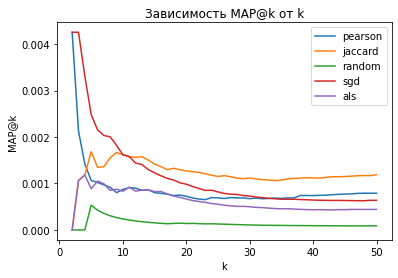

In [147]:
preds_all = [preds_pears, preds_jaccard, preds_random, preds_sgd, preds_als]
names = ['pearson', 'jaccard', 'random', 'sgd', 'als']

for name, preds in zip(names, preds_all):
    scores = []
    for k in range(k_max):
        scores.append(mapk(test_relevant, preds, k=k))
    plt.plot(range(1, k_max + 1), scores, label=name)
plt.title('Зависимость MAP@k от k')
plt.ylabel('MAP@k')
plt.xlabel('k')
plt.legend()
plt.show()

In [151]:
scores_sgd = []
scores_als = []
n_iters = np.arange(3, 20, 2)
for n_iter in tqdm(n_iters):
    model = HiddenVars(train_ratings, mode='sgd', dim=85, lamb=3.75, lr=8.57e-4)
    model.fit(num_iters=n_iter)
    preds = model.get_test_recommendations(3)
    scores_sgd.append(mapk(test_relevant, preds, k=3))
    
    model = HiddenVars(train_ratings, mode='als', dim=344, lamb=0.001677, lr=0.002549)
    model.fit(num_iters=n_iter)
    preds = model.get_test_recommendations(1)
    scores_als.append(mapk(test_relevant, preds, k=3))

  0%|          | 0/9 [00:00<?, ?it/s]

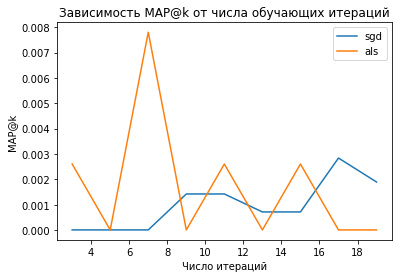

In [153]:
plt.plot(n_iters, scores_sgd, label='sgd')
plt.plot(n_iters, scores_als, label='als')
plt.title('Зависимость MAP@k от числа обучающих итераций')
plt.ylabel('MAP@k')
plt.xlabel('Число итераций')
plt.legend()
plt.show()

Я бы выбрал для этой задчи sgd, т.к. его  площадь под графиком (в зависимости от k) больше чем у остальных, т.е. он имеет лучшую предсказывающую способность (особенно на небольших k).

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [154]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [155]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
50864,Давай разлуке запретим,"['Стас Михайлов', 'Тамара Гвердцители']",0.541690
49066,Я люблю тебя до Луны,['Ирина Дубцова'],0.541690
26186,морячок,['Ночные Снайперы'],0.539538
5515,Романс,['Сплин'],0.531752
42454,Сумасшедшая,['Ани Лорак'],0.527350
49245,Toukassé,['Shanguy'],0.518094
51087,Любовь найдёт,['Юлия Савичева'],0.517549
36985,Pumped Up,['Klingande'],0.508543
6412,White Flag,['Dido'],0.491133
